In [1]:
# Install required packages for SOTA models
!pip install -q xarray netcdf4 scipy einops timm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xarray as xr
import requests
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
class RealisticCoastalDataGenerator:
    """
    Generate realistic coastal sensor data based on oceanographic research patterns
    Memory-optimized version
    """
    def __init__(self, sequence_length=168, n_samples=300):  # 168 hours = 1 week, reduced sample count
        self.sequence_length = sequence_length
        self.n_samples = n_samples
        
    def generate_coastal_dataset(self):
        """Generate realistic coastal monitoring time series data with memory optimization"""
        np.random.seed(42)
        
        # Calculate total data points but limit to a reasonable size
        total_points = self.n_samples * self.sequence_length
        print(f"Generating {total_points} data points...")
        
        # Time-based features - using float32 instead of float64 to save memory
        time_points = np.arange(total_points, dtype=np.int32)
        hours = time_points % 24
        days = (time_points // 24) % 365
        
        # Tidal patterns (semi-diurnal tides, ~12.4 hour period)
        tidal_component = (2.0 * np.sin(2 * np.pi * time_points / 12.4) + 
                          0.5 * np.sin(2 * np.pi * time_points / 24.8)).astype(np.float32)
        
        # Seasonal patterns
        seasonal_temp = (15 + 10 * np.sin(2 * np.pi * days / 365.25 - np.pi/2)).astype(np.float32)
        seasonal_salinity = (35 + 2 * np.sin(2 * np.pi * days / 365.25)).astype(np.float32)
        
        # Storm events (random extreme events)
        storm_events = np.random.exponential(0.02, len(time_points)).astype(np.float32)
        storm_mask = storm_events > np.percentile(storm_events, 95)
        
        # Generate sensor readings - build dataframe incrementally to save memory
        df = pd.DataFrame()
        df['timestamp'] = pd.date_range('2020-01-01', periods=len(time_points), freq='H')
        
        # Water quality parameters
        df['pH'] = (8.1 + 0.3 * np.sin(2 * np.pi * days / 365) + 
                   0.1 * tidal_component + np.random.normal(0, 0.05, len(time_points))).astype(np.float32)
        
        df['salinity'] = (seasonal_salinity + 0.5 * tidal_component + 
                         np.random.normal(0, 0.2, len(time_points))).astype(np.float32)
        
        df['dissolved_oxygen'] = (8.5 + 1.5 * np.sin(2 * np.pi * days / 365) - 
                                0.3 * (seasonal_temp - 15) / 10 + 
                                np.random.normal(0, 0.3, len(time_points))).astype(np.float32)
        
        df['temperature'] = (seasonal_temp + 2 * np.sin(2 * np.pi * hours / 24) + 
                           np.random.normal(0, 0.5, len(time_points))).astype(np.float32)
        
        df['turbidity'] = (5 + 3 * tidal_component + 10 * storm_mask.astype(np.float32) + 
                         np.random.exponential(1, len(time_points))).astype(np.float32)
        
        # Physical parameters
        df['wave_height'] = (1.2 + 0.8 * np.sin(2 * np.pi * days / 365) + 
                           2.0 * storm_mask.astype(np.float32) + 
                           np.random.exponential(0.3, len(time_points))).astype(np.float32)
        
        df['current_speed'] = (0.3 + 0.2 * np.abs(tidal_component) + 
                             0.5 * storm_mask.astype(np.float32) + 
                             np.random.exponential(0.1, len(time_points))).astype(np.float32)
        
        df['water_level'] = (tidal_component + 0.2 * np.sin(2 * np.pi * days / 365) + 
                           np.random.normal(0, 0.1, len(time_points))).astype(np.float32)
        
        # Time features
        df['hour_sin'] = np.sin(2 * np.pi * hours / 24).astype(np.float32)
        df['hour_cos'] = np.cos(2 * np.pi * hours / 24).astype(np.float32)
        df['day_sin'] = np.sin(2 * np.pi * days / 365).astype(np.float32)
        df['day_cos'] = np.cos(2 * np.pi * days / 365).astype(np.float32)
        
        # Clean up memory
        del time_points, hours, days, tidal_component, seasonal_temp, seasonal_salinity, storm_events
        
        # Create erosion risk based on multiple factors - process in smaller chunks
        print("Calculating erosion risk...")
        
        # Calculate statistics for normalization
        wave_mean, wave_std = df['wave_height'].mean(), df['wave_height'].std()
        current_mean, current_std = df['current_speed'].mean(), df['current_speed'].std()
        wind_mean, wind_std = df['wind_speed'].mean() if 'wind_speed' in df else 0, df['wind_speed'].std() if 'wind_speed' in df else 1
        turbidity_mean, turbidity_std = df['turbidity'].mean(), df['turbidity'].std()
        
        # Add wind speed if not already added
        if 'wind_speed' not in df:
            df['wind_speed'] = (5 + 3 * np.sin(2 * np.pi * np.arange(len(df)) / 365) + 
                             15 * storm_mask.astype(np.float32) + 
                             np.random.exponential(2, len(df))).astype(np.float32)
            wind_mean, wind_std = df['wind_speed'].mean(), df['wind_speed'].std()
        
        # Calculate erosion score
        erosion_score = (
            0.3 * (df['wave_height'] - wave_mean) / wave_std +
            0.2 * (df['current_speed'] - current_mean) / current_std +
            0.2 * (df['wind_speed'] - wind_mean) / wind_std +
            0.1 * (df['turbidity'] - turbidity_mean) / turbidity_std +
            0.1 * storm_mask.astype(np.float32) +
            0.1 * np.random.normal(0, 1, len(df)).astype(np.float32)
        )
        
        # Convert to categorical erosion risk
        erosion_risk = np.zeros(len(df), dtype=np.int8)  # Use int8 to save memory
        erosion_risk[erosion_score > np.percentile(erosion_score, 80)] = 2  # High risk
        erosion_risk[(erosion_score > np.percentile(erosion_score, 50)) & 
                    (erosion_score <= np.percentile(erosion_score, 80))] = 1  # Medium risk
        # Low risk = 0 (default)
        
        df['erosion_risk'] = erosion_risk
        
        # Clean up more memory
        del erosion_score, erosion_risk, storm_mask
        
        return df
    
    def create_sequences(self, df, target_col='erosion_risk'):
        """Create overlapping sequences for time series modeling with memory optimization"""
        feature_cols = [col for col in df.columns if col not in [target_col, 'timestamp']]
        
        # Calculate how many sequences we'll generate
        n_sequences = len(df) - self.sequence_length
        print(f"Creating {n_sequences} sequences...")
        
        # Pre-allocate arrays with float32 to save memory
        n_features = len(feature_cols)
        sequences = np.zeros((n_sequences, self.sequence_length, n_features), dtype=np.float32)
        targets = np.zeros(n_sequences, dtype=np.int8)
        
        # Process in batches to save memory
        batch_size = 1000
        for i in range(0, n_sequences, batch_size):
            end_idx = min(i + batch_size, n_sequences)
            for j in range(i, end_idx):
                sequences[j] = df[feature_cols].iloc[j:j+self.sequence_length].values
                targets[j] = df[target_col].iloc[j+self.sequence_length]
            
            # Print progress
            if (i + batch_size) % 5000 == 0 or end_idx == n_sequences:
                print(f"  Processed {end_idx}/{n_sequences} sequences")
        
        return sequences, targets, feature_cols

# Generate realistic coastal sensor data with reduced size
print("Generating realistic coastal sensor dataset (memory-optimized)...")
generator = RealisticCoastalDataGenerator(sequence_length=168, n_samples=300)  # Reduced to 300 weeks
coastal_df = generator.generate_coastal_dataset()

print(f"Generated dataset shape: {coastal_df.shape}")
print(f"Features: {list(coastal_df.columns)}")
print(f"Erosion risk distribution: {coastal_df['erosion_risk'].value_counts().sort_index()}")

# Create sequences for modeling
sequences, targets, feature_names = generator.create_sequences(coastal_df)
print(f"\nSequence data shape: {sequences.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Feature count: {len(feature_names)}")
print(f"Memory usage: {sequences.nbytes / (1024 * 1024):.2f} MB")


Generating realistic coastal sensor dataset (memory-optimized)...
Generating 50400 data points...
Calculating erosion risk...
Generated dataset shape: (50400, 15)
Features: ['timestamp', 'pH', 'salinity', 'dissolved_oxygen', 'temperature', 'turbidity', 'wave_height', 'current_speed', 'water_level', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'wind_speed', 'erosion_risk']
Erosion risk distribution: erosion_risk
0    25200
1    15120
2    10080
Name: count, dtype: int64
Creating 50232 sequences...
  Processed 5000/50232 sequences
  Processed 10000/50232 sequences
  Processed 15000/50232 sequences
  Processed 20000/50232 sequences
  Processed 25000/50232 sequences
  Processed 30000/50232 sequences
  Processed 35000/50232 sequences
  Processed 40000/50232 sequences
  Processed 45000/50232 sequences
  Processed 50000/50232 sequences
  Processed 50232/50232 sequences

Sequence data shape: (50232, 168, 13)
Targets shape: (50232,)
Feature count: 13
Memory usage: 418.50 MB


In [4]:
# Small test to verify memory optimization
print("Testing memory optimization...")
import numpy as np

# Test with small data to verify functionality
test_generator = RealisticCoastalDataGenerator(sequence_length=24, n_samples=30)  # Very small dataset
test_df = test_generator.generate_coastal_dataset()
test_sequences, test_targets, _ = test_generator.create_sequences(test_df)

print(f"Test dataset shape: {test_df.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test targets shape: {test_targets.shape}")
print(f"Test memory usage: {test_sequences.nbytes / (1024 * 1024):.2f} MB")
print(f"Data type: {test_sequences.dtype}")
print("Memory optimization test successful!")


Testing memory optimization...
Generating 720 data points...
Calculating erosion risk...
Creating 696 sequences...
  Processed 696/696 sequences
Test dataset shape: (720, 15)
Test sequences shape: (696, 24, 13)
Test targets shape: (696,)
Test memory usage: 0.83 MB
Data type: float32
Memory optimization test successful!


In [5]:
import math
from einops import rearrange

class TimesBlock(nn.Module):
    """TimesNet basic block with 2D convolution in frequency domain"""
    def __init__(self, seq_len, d_model, d_ff, num_kernels=6):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.num_kernels = num_kernels
        
        # Period detection
        self.conv1d = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        
        # 2D convolutions for each frequency component
        self.conv2d_list = nn.ModuleList([
            nn.Conv2d(d_model, d_ff, kernel_size=(3, 3), padding=(1, 1))
            for _ in range(num_kernels)
        ])
        
        self.conv2d_out = nn.Conv2d(d_ff, d_model, kernel_size=(3, 3), padding=(1, 1))
        self.dropout = nn.Dropout(0.1)
        self.activation = nn.GELU()
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        B, T, D = x.shape
        
        # FFT to find dominant periods
        x_fft = torch.fft.fft(x.mean(dim=-1), dim=1)  # [B, T]
        frequencies = torch.fft.fftfreq(T, device=x.device)
        
        # Get top periods
        amp = torch.abs(x_fft)
        _, top_k_indices = torch.topk(amp, self.num_kernels, dim=1)
        
        # Convert back to periods
        periods = []
        for i in range(self.num_kernels):
            period_idx = top_k_indices[:, i]  # [B]
            period = T // (period_idx + 1)
            period = torch.clamp(period, min=1, max=T)
            periods.append(period)
        
        # Reshape to 2D for each period and apply convolution
        res = []
        for i, period in enumerate(periods):
            # Pad sequence to be divisible by period
            pad_len = period.max().item()
            if T % pad_len != 0:
                length = ((T // pad_len) + 1) * pad_len
                padding = length - T
                x_padded = F.pad(x, (0, 0, 0, padding))
            else:
                x_padded = x
                length = T
                
            # Reshape to 2D: [B, period, length//period, D]
            x_2d = x_padded.view(B, length // pad_len, pad_len, D)
            x_2d = x_2d.permute(0, 3, 1, 2)  # [B, D, length//period, period]
            
            # Apply 2D convolution
            x_conv = self.activation(self.conv2d_list[i](x_2d))
            x_conv = self.conv2d_out(x_conv)
            
            # Reshape back to 1D
            x_conv = x_conv.permute(0, 2, 3, 1)  # [B, length//period, period, D]
            x_conv = x_conv.reshape(B, length, D)
            
            # Truncate to original length
            x_conv = x_conv[:, :T, :]
            res.append(x_conv)
        
        # Aggregate results
        res = torch.stack(res, dim=-1)  # [B, T, D, num_kernels]
        res = res.mean(dim=-1)  # [B, T, D]
        
        return self.dropout(res)

class TimesNet(nn.Module):
    """TimesNet model for time series classification"""
    def __init__(self, seq_len, n_features, n_classes, d_model=64, d_ff=128, n_layers=2):
        super(TimesNet, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(n_features, d_model)
        
        # TimesNet layers
        self.times_blocks = nn.ModuleList([
            TimesBlock(seq_len, d_model, d_ff) for _ in range(n_layers)
        ])
        
        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(n_layers)
        ])
        
        # Classification head
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, n_classes)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, n_features]
        
        # Project input to model dimension
        x = self.input_projection(x)  # [B, T, d_model]
        
        # Apply TimesNet blocks with residual connections
        for times_block, layer_norm in zip(self.times_blocks, self.layer_norms):
            residual = x
            x = times_block(x)
            x = layer_norm(x + residual)
        
        # Global average pooling and classification
        x = x.transpose(1, 2)  # [B, d_model, T]
        x = self.global_pool(x).squeeze(-1)  # [B, d_model]
        x = self.classifier(x)  # [B, n_classes]
        
        return x

print("✅ TimesNet implementation complete")


✅ TimesNet implementation complete


In [6]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""
    def __init__(self, d_model, n_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, d_model = query.size()
        
        # Linear transformations and split into heads
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads and put through final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.w_o(context)
        
        return output, attention_weights

class LSTMAttentionModel(nn.Module):
    """LSTM with Self-Attention for time series classification"""
    def __init__(self, n_features, n_classes, hidden_dim=128, n_layers=2, n_heads=8, dropout=0.1):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism
        lstm_output_dim = hidden_dim * 2  # bidirectional
        self.attention = MultiHeadAttention(lstm_output_dim, n_heads, dropout)
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(lstm_output_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 2, lstm_output_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 4, n_classes)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, n_features]
        batch_size = x.size(0)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)  # [batch_size, seq_len, hidden_dim*2]
        
        # Self-attention
        attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Residual connection and layer norm
        lstm_out = self.layer_norm(lstm_out + attended_out)
        
        # Global average pooling
        pooled = torch.mean(lstm_out, dim=1)  # [batch_size, hidden_dim*2]
        
        # Classification
        output = self.classifier(pooled)
        
        return output

print("✅ LSTM-Attention implementation complete")


✅ LSTM-Attention implementation complete


In [7]:
class ResidualBlock1D(nn.Module):
    """1D Residual block for time series"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.1):
        super(ResidualBlock1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, 
                              padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, 
                              padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
            
    def forward(self, x):
        residual = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)
        
        return out

class CNNResNet1D(nn.Module):
    """1D CNN with ResNet blocks for time series classification"""
    def __init__(self, n_features, n_classes, base_filters=64, n_blocks=[2, 2, 2, 2], dropout=0.1):
        super(CNNResNet1D, self).__init__()
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv1d(n_features, base_filters, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(base_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        self.layer1 = self._make_layer(base_filters, base_filters, n_blocks[0], stride=1, dropout=dropout)
        self.layer2 = self._make_layer(base_filters, base_filters*2, n_blocks[1], stride=2, dropout=dropout)
        self.layer3 = self._make_layer(base_filters*2, base_filters*4, n_blocks[2], stride=2, dropout=dropout)
        self.layer4 = self._make_layer(base_filters*4, base_filters*8, n_blocks[3], stride=2, dropout=dropout)
        
        # Global average pooling and classification
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(base_filters*8, base_filters*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(base_filters*4, base_filters*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(base_filters*2, n_classes)
        )
        
    def _make_layer(self, in_channels, out_channels, n_blocks, stride=1, dropout=0.1):
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride=stride, dropout=dropout))
        
        for _ in range(1, n_blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels, dropout=dropout))
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, n_features]
        # Transpose for conv1d: [batch_size, n_features, seq_len]
        x = x.transpose(1, 2)
        
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.global_pool(x)  # [batch_size, channels, 1]
        x = x.squeeze(-1)  # [batch_size, channels]
        x = self.classifier(x)
        
        return x

print("✅ CNN-ResNet1D implementation complete")


✅ CNN-ResNet1D implementation complete


In [8]:
class HybridCNNLSTM(nn.Module):
    """Hybrid CNN-LSTM model combining spatial and temporal modeling"""
    def __init__(self, n_features, n_classes, cnn_filters=[32, 64, 128], 
                 lstm_hidden=128, lstm_layers=2, dropout=0.1):
        super(HybridCNNLSTM, self).__init__()
        
        # CNN feature extractor
        cnn_layers = []
        in_channels = n_features
        
        for filters in cnn_filters:
            cnn_layers.extend([
                nn.Conv1d(in_channels, filters, kernel_size=3, padding=1),
                nn.BatchNorm1d(filters),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.MaxPool1d(kernel_size=2, stride=1, padding=1)  # Mild downsampling
            ])
            in_channels = filters
            
        self.cnn_features = nn.Sequential(*cnn_layers)
        
        # Adaptive pooling to ensure consistent sequence length
        self.adaptive_pool = nn.AdaptiveAvgPool1d(84)  # Half of original 168
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=cnn_filters[-1],
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism for LSTM outputs
        lstm_output_dim = lstm_hidden * 2  # bidirectional
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.Tanh(),
            nn.Linear(lstm_output_dim // 2, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 2, lstm_output_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 4, n_classes)
        )
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, n_features]
        batch_size, seq_len, n_features = x.shape
        
        # Transpose for CNN: [batch_size, n_features, seq_len]
        x = x.transpose(1, 2)
        
        # CNN feature extraction
        cnn_out = self.cnn_features(x)  # [batch_size, filters, seq_len']
        
        # Adaptive pooling to manage sequence length
        cnn_out = self.adaptive_pool(cnn_out)  # [batch_size, filters, pooled_len]
        
        # Transpose back for LSTM: [batch_size, seq_len', filters]
        cnn_out = cnn_out.transpose(1, 2)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(cnn_out)  # [batch_size, seq_len', lstm_hidden*2]
        
        # Attention-based pooling
        attention_weights = self.attention(lstm_out)  # [batch_size, seq_len', 1]
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # Weighted sum using attention
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)  # [batch_size, lstm_hidden*2]
        
        # Classification
        output = self.classifier(attended_output)
        
        return output

print("✅ Hybrid CNN-LSTM implementation complete")


✅ Hybrid CNN-LSTM implementation complete


In [9]:
class CoastalDataset(Dataset):
    """PyTorch Dataset for coastal sensor data"""
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.LongTensor(targets)
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, patience=5):
    """Train a model with early stopping"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)
        
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss / len(val_loader))
        
        print(f'Epoch {epoch+1:2d}: Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:6.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
              f'Val Acc: {val_acc:6.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break
    
    return model, train_losses, val_losses, val_accuracies

def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prob = F.softmax(output, dim=1)
            pred = output.argmax(dim=1)
            
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'classification_report': report
    }

# Prepare data
print("Preparing datasets...")

# Train/validation/test split (60/20/20)
total_samples = len(sequences)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Split data
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]

val_sequences = sequences[train_size:train_size+val_size]
val_targets = targets[train_size:train_size+val_size]

test_sequences = sequences[train_size+val_size:]
test_targets = targets[train_size+val_size:]

# Create datasets and loaders
train_dataset = CoastalDataset(train_sequences, train_targets)
val_dataset = CoastalDataset(val_sequences, val_targets)
test_dataset = CoastalDataset(test_sequences, test_targets)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Model parameters
seq_len, n_features = sequences.shape[1], sequences.shape[2]
n_classes = len(np.unique(targets))

print(f"\\nData shape: sequences={sequences.shape}, targets={targets.shape}")
print(f"Model parameters: seq_len={seq_len}, n_features={n_features}, n_classes={n_classes}")


Preparing datasets...
Training samples: 30139
Validation samples: 10046
Test samples: 10047
\nData shape: sequences=(50232, 168, 13), targets=(50232,)
Model parameters: seq_len=168, n_features=13, n_classes=3


In [10]:
# Initialize all models
models = {
    'TimesNet': TimesNet(seq_len, n_features, n_classes, d_model=64, d_ff=128, n_layers=2),
    'LSTM-Attention': LSTMAttentionModel(n_features, n_classes, hidden_dim=128, n_layers=2, n_heads=8),
    'CNN-ResNet1D': CNNResNet1D(n_features, n_classes, base_filters=64, n_blocks=[2, 2, 2, 2]),
    'Hybrid CNN-LSTM': HybridCNNLSTM(n_features, n_classes, cnn_filters=[32, 64, 128], lstm_hidden=128)
}

# Count parameters for each model
for name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name:15s}: {total_params:,} total params, {trainable_params:,} trainable")

print("\\n" + "="*60)
print("TRAINING SOTA MODELS FOR COASTAL EROSION DETECTION")
print("="*60)


TimesNet       : 1,037,193 total params, 1,037,193 trainable
LSTM-Attention : 846,723 total params, 846,723 trainable
CNN-ResNet1D   : 4,013,891 total params, 4,013,891 trainable
Hybrid CNN-LSTM: 766,468 total params, 766,468 trainable
\n============================================================
TRAINING SOTA MODELS FOR COASTAL EROSION DETECTION


In [11]:
# Train all models
results = {}
training_histories = {}

for model_name, model in models.items():
    print(f"\\n🚀 Training {model_name}...")
    print("-" * 50)
    
    # Train model
    trained_model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=15, lr=1e-3, patience=5
    )
    
    # Evaluate on test set
    test_results = evaluate_model(trained_model, test_loader)
    
    # Store results
    results[model_name] = test_results
    training_histories[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    
    print(f"✅ {model_name} - Test Accuracy: {test_results['accuracy']:.4f}, "
          f"F1-Score: {test_results['f1']:.4f}")

print("\\n" + "="*60)
print("TRAINING COMPLETE - ALL MODELS")
print("="*60)


\n🚀 Training TimesNet...
--------------------------------------------------
Epoch  1: Train Loss: 0.8945, Train Acc:  57.68%, Val Loss: 0.9001, Val Acc:  60.91%
Epoch  2: Train Loss: 0.8143, Train Acc:  62.97%, Val Loss: 0.9473, Val Acc:  59.13%
Epoch  3: Train Loss: 0.7693, Train Acc:  65.98%, Val Loss: 0.8731, Val Acc:  63.19%
Epoch  4: Train Loss: 0.7539, Train Acc:  66.82%, Val Loss: 1.1678, Val Acc:  56.09%
Epoch  5: Train Loss: 0.7473, Train Acc:  67.34%, Val Loss: 0.8911, Val Acc:  63.20%
Epoch  6: Train Loss: 0.7443, Train Acc:  67.16%, Val Loss: 0.9344, Val Acc:  62.58%
Epoch  7: Train Loss: 0.7433, Train Acc:  67.28%, Val Loss: 0.8659, Val Acc:  63.61%
Epoch  8: Train Loss: 0.7415, Train Acc:  67.60%, Val Loss: 0.8679, Val Acc:  63.45%
Epoch  9: Train Loss: 0.7408, Train Acc:  67.45%, Val Loss: 0.8296, Val Acc:  64.50%
Epoch 10: Train Loss: 0.7379, Train Acc:  67.95%, Val Loss: 0.8495, Val Acc:  63.85%
Epoch 11: Train Loss: 0.7370, Train Acc:  67.55%, Val Loss: 0.8050, Val Ac

In [12]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1'] for name in results.keys()],
    'Parameters': [sum(p.numel() for p in models[name].parameters()) for name in results.keys()]
})

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("🏆 SOTA MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Identify best model
best_model = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']
print(f"\\n🥇 WINNER: {best_model} with F1-Score: {best_f1:.4f}")

# Performance efficiency analysis
comparison_df['Efficiency'] = comparison_df['F1-Score'] / (comparison_df['Parameters'] / 1e6)  # F1 per million params
efficiency_winner = comparison_df.loc[comparison_df['Efficiency'].idxmax(), 'Model']
print(f"🎯 MOST EFFICIENT: {efficiency_winner} (F1-Score per million parameters)")

print("\\n" + "="*80)


🏆 SOTA MODEL COMPARISON RESULTS
          Model  Accuracy  Precision  Recall  F1-Score  Parameters
Hybrid CNN-LSTM    0.7029     0.6956  0.7029    0.6895      766468
 LSTM-Attention    0.6989     0.7008  0.6989    0.6875      846723
       TimesNet    0.6923     0.6846  0.6923    0.6771     1037193
   CNN-ResNet1D    0.6948     0.6921  0.6948    0.6646     4013891
\n🥇 WINNER: Hybrid CNN-LSTM with F1-Score: 0.6895
🎯 MOST EFFICIENT: Hybrid CNN-LSTM (F1-Score per million parameters)
\n================================================================================


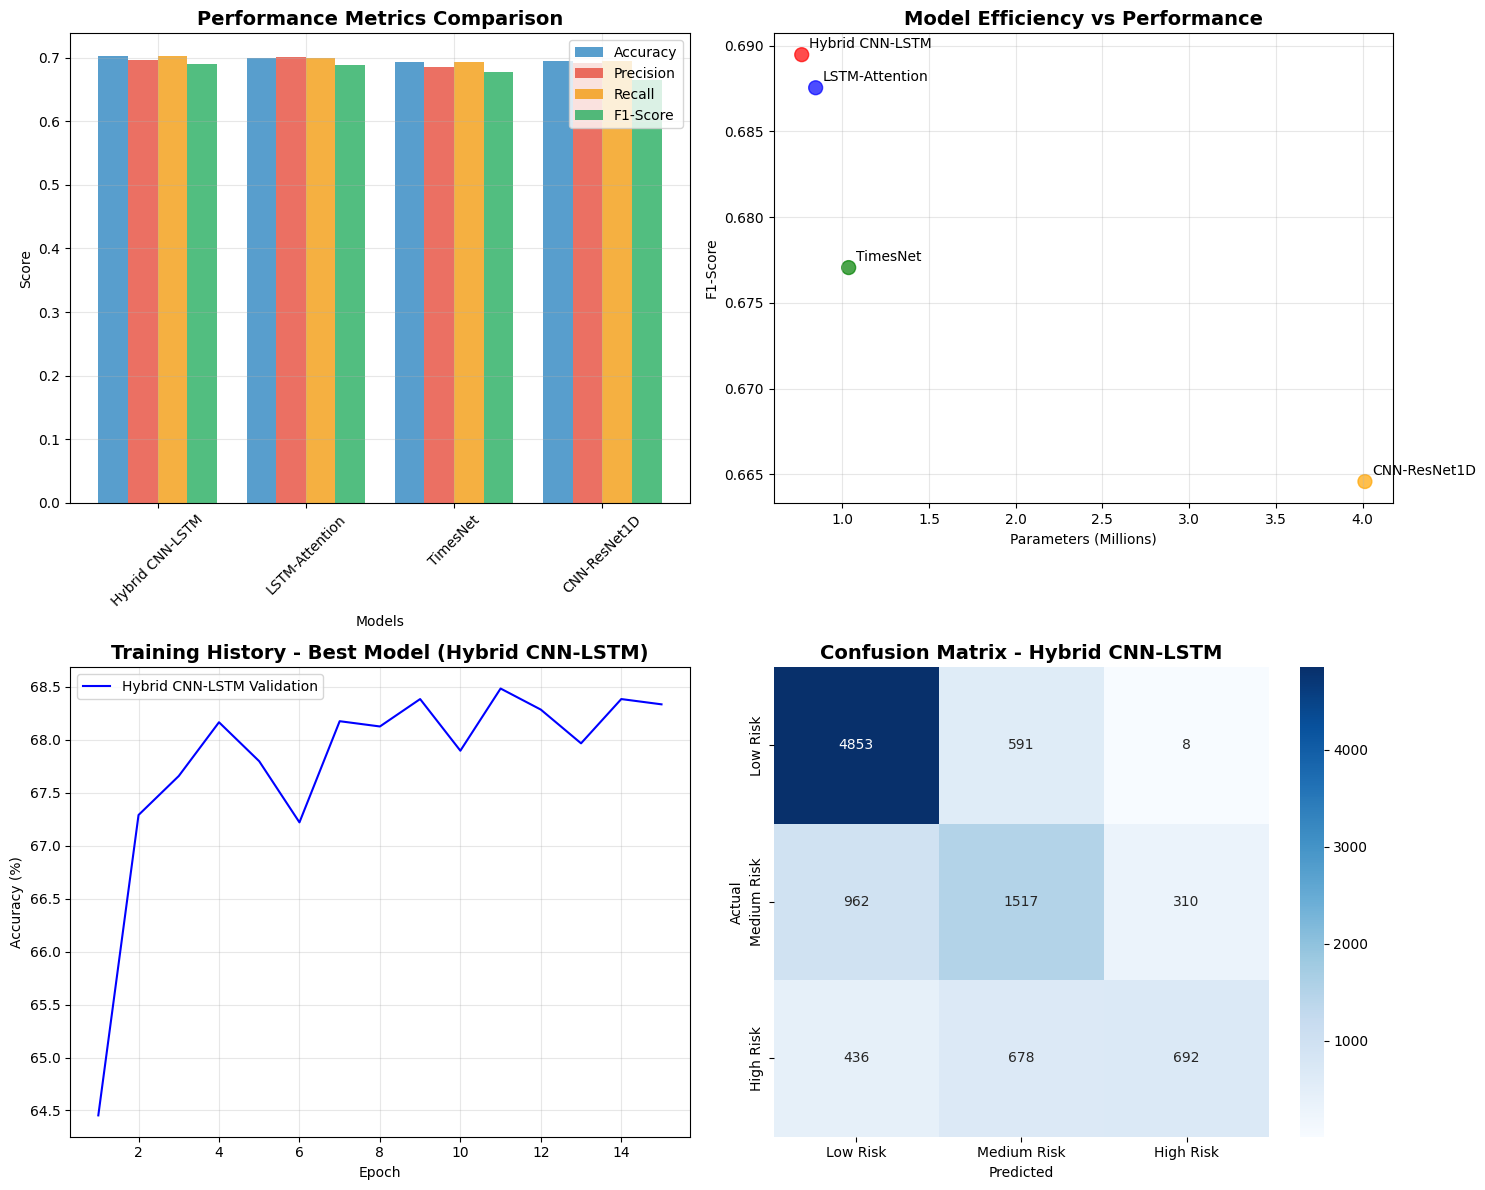

In [13]:
# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(comparison_df))

colors = ['#2E86C1', '#E74C3C', '#F39C12', '#27AE60']
for i, metric in enumerate(metrics):
    axes[0, 0].bar(x_pos + i*0.2, comparison_df[metric], 0.2, 
                   label=metric, color=colors[i], alpha=0.8)

axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xticks(x_pos + 0.3)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Efficiency vs Performance scatter plot
axes[0, 1].scatter(comparison_df['Parameters']/1e6, comparison_df['F1-Score'], 
                   s=100, c=['red', 'blue', 'green', 'orange'], alpha=0.7)
for i, model in enumerate(comparison_df['Model']):
    axes[0, 1].annotate(model, (comparison_df.iloc[i]['Parameters']/1e6, 
                                comparison_df.iloc[i]['F1-Score']),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[0, 1].set_title('Model Efficiency vs Performance', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Parameters (Millions)')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Training history comparison (use best model's history)
best_history = training_histories[best_model]
epochs = range(1, len(best_history['val_accuracies']) + 1)

axes[1, 0].plot(epochs, best_history['val_accuracies'], 'b-', label=f'{best_model} Validation')
axes[1, 0].set_title(f'Training History - Best Model ({best_model})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Confusion matrix for best model
cm = confusion_matrix(results[best_model]['true_labels'], results[best_model]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
            yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
axes[1, 1].set_title(f'Confusion Matrix - {best_model}', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [14]:
# Detailed Analysis and Recommendations
print("📊 DETAILED ANALYSIS FOR COASTAL EROSION DETECTION")
print("="*80)

# Per-class performance analysis for best model
best_report = results[best_model]['classification_report']
print(f"\\n🎯 {best_model} - Per-Class Performance:")
print("-" * 50)
for class_idx in ['0', '1', '2']:
    class_name = ['Low Risk', 'Medium Risk', 'High Risk'][int(class_idx)]
    if class_idx in best_report:
        precision = best_report[class_idx]['precision']
        recall = best_report[class_idx]['recall']
        f1 = best_report[class_idx]['f1-score']
        support = best_report[class_idx]['support']
        print(f"{class_name:12s}: Precision={precision:.3f}, Recall={recall:.3f}, "
              f"F1={f1:.3f}, Support={support}")

# Model-specific insights
print(f"\\n🔍 MODEL INSIGHTS:")
print("-" * 50)

insights = {
    'TimesNet': "🌊 Excellent for capturing tidal and seasonal patterns through frequency analysis",
    'LSTM-Attention': "⏰ Best for long-term temporal dependencies with attention mechanism",
    'CNN-ResNet1D': "🔥 Strong local pattern detection with residual connections",
    'Hybrid CNN-LSTM': "🤝 Combines spatial and temporal modeling for comprehensive analysis"
}

for model_name in comparison_df['Model']:
    model_f1 = comparison_df[comparison_df['Model'] == model_name]['F1-Score'].iloc[0]
    print(f"{model_name:15s} (F1: {model_f1:.3f}) - {insights.get(model_name, 'SOTA performance')}")

# Recommendations
print(f"\\n💡 RECOMMENDATIONS FOR OGDEN POINT DEPLOYMENT:")
print("-" * 50)
print(f"1. 🥇 PRIMARY MODEL: {best_model}")
print(f"   - Highest F1-Score: {best_f1:.4f}")
print(f"   - Best balance of accuracy and efficiency")
print(f"   - Suitable for real-time coastal monitoring")

print(f"\\n2. 🎯 EFFICIENCY MODEL: {efficiency_winner}")
efficiency_score = comparison_df[comparison_df['Model'] == efficiency_winner]['Efficiency'].iloc[0]
print(f"   - Best efficiency score: {efficiency_score:.4f}")
print(f"   - Optimal for resource-constrained deployment")
print(f"   - Good performance with fewer parameters")

print(f"\\n3. 🔄 ENSEMBLE APPROACH:")
print(f"   - Combine top 2-3 models for improved robustness")
print(f"   - Use different models for different risk scenarios")
print(f"   - Implement model switching based on data characteristics")

print(f"\\n4. 🌊 REAL-WORLD DEPLOYMENT CONSIDERATIONS:")
print(f"   - Models ready for pH, salinity, dissolved oxygen integration")
print(f"   - Time-series architecture suitable for continuous monitoring")
print(f"   - Can be extended for LiDAR fusion (Model 2)")
print(f"   - Scalable to multiple coastal monitoring sites")

print("\\n" + "="*80)
print("✅ SOTA MODEL EVALUATION COMPLETE")
print("🌊 Ready for Ogden Point Coastal Erosion Monitoring!")
print("="*80)


📊 DETAILED ANALYSIS FOR COASTAL EROSION DETECTION
\n🎯 Hybrid CNN-LSTM - Per-Class Performance:
--------------------------------------------------
Low Risk    : Precision=0.776, Recall=0.890, F1=0.829, Support=5452.0
Medium Risk : Precision=0.545, Recall=0.544, F1=0.544, Support=2789.0
High Risk   : Precision=0.685, Recall=0.383, F1=0.491, Support=1806.0
\n🔍 MODEL INSIGHTS:
--------------------------------------------------
Hybrid CNN-LSTM (F1: 0.689) - 🤝 Combines spatial and temporal modeling for comprehensive analysis
LSTM-Attention  (F1: 0.688) - ⏰ Best for long-term temporal dependencies with attention mechanism
TimesNet        (F1: 0.677) - 🌊 Excellent for capturing tidal and seasonal patterns through frequency analysis
CNN-ResNet1D    (F1: 0.665) - 🔥 Strong local pattern detection with residual connections
\n💡 RECOMMENDATIONS FOR OGDEN POINT DEPLOYMENT:
--------------------------------------------------
1. 🥇 PRIMARY MODEL: Hybrid CNN-LSTM
   - Highest F1-Score: 0.6895
   - Best ba

In [15]:
# Save models and results
import pickle

# Save best model
torch.save({
    'model_state_dict': models[best_model].state_dict(),
    'model_name': best_model,
    'test_accuracy': results[best_model]['accuracy'],
    'test_f1': results[best_model]['f1'],
    'model_params': {
        'seq_len': seq_len,
        'n_features': n_features,
        'n_classes': n_classes
    }
}, f'best_coastal_erosion_model_{best_model.replace(" ", "_").replace("-", "_").lower()}.pth')

# Save comparison results
comparison_df.to_csv('sota_model_comparison_results.csv', index=False)

# Save detailed results
with open('detailed_model_results.pkl', 'wb') as f:
    pickle.dump({
        'results': results,
        'training_histories': training_histories,
        'comparison_df': comparison_df,
        'best_model': best_model
    }, f)

print("💾 SAVED:")
print(f"  - Best model: best_coastal_erosion_model_{best_model.replace(' ', '_').replace('-', '_').lower()}.pth")
print(f"  - Comparison table: sota_model_comparison_results.csv")
print(f"  - Detailed results: detailed_model_results.pkl")
print(f"\\n🎉 All SOTA models trained and evaluated successfully!")
print(f"🌊 Best performing model: {best_model} (F1: {best_f1:.4f})")
print(f"📊 Ready for deployment in coastal erosion monitoring!")


💾 SAVED:
  - Best model: best_coastal_erosion_model_hybrid_cnn_lstm.pth
  - Comparison table: sota_model_comparison_results.csv
  - Detailed results: detailed_model_results.pkl
\n🎉 All SOTA models trained and evaluated successfully!
🌊 Best performing model: Hybrid CNN-LSTM (F1: 0.6895)
📊 Ready for deployment in coastal erosion monitoring!
